# Bank Clients Anomaly Prediction Project with Data Engineering




### The aim of this project was to: 
- ingest raw, real-world data from several tables stored in Google Cloud 
- build unsupervised anomaly detection model



## Data ingestion from Google Cloud Bucket: 
- one excel file "Banking Clients' with three data sheets: 'Clients - Banking', 'Nationality', 'Clients';
- two .txt files: 'Banking Contact', 'Investment Advisor'


In [1]:
# Import nesseccary libriaries for data handling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)


# Feature Processing and Model (Scikit-learn processing, etc. )
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
from sklearn.inspection import DecisionBoundaryDisplay

# Model registering
import os
import joblib

# API / Cloud 
import requests
import io
from google.cloud import storage
from typing import Dict, Optional, Sequence, Tuple
from google.cloud import aiplatform
from google.cloud.aiplatform import explain


In [2]:
# Use the default credentials to authenticate to Google Cloud 
# Create and download Service account key under IAM & Admin Service Accounts (it's a json file), 
# download it and set the environment variable: 
# set GOOGLE_APPLICATION_CREDENTIALS="path/to/your/service-account-file.json" 

import io
import requests
from google.cloud import storage
from datetime import timedelta 

# Resources needed to download data from
bucket_name = 'bank_clients_raw_data'
excel_blob_name = 'Banking Clients.xlsx'
txt1_blob_name = 'Banking Contact.txt'
txt2_blob_name = 'Investment Advisor.txt'

# Connect to Google Cloud with a handler
def initialize_gcs_client():
    try: 
        # Path to your service account key file
        key_path = r"C:\Users\user\PYTHON_Data Science\continual-air-441820-k0-40260413fce7.json"

        # Set the environment variable
        os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = key_path

        # Initialize the Google Cloud Storage client
        gcs_client = storage.Client()
        return gcs_client
        
    except Exception as e: 
         print(f"Error connecting to Google Cloud: {e}")

# Initialize the handler itself - global var, needed later for uploading on gcs
gcs_client = initialize_gcs_client()

def get_blob_url(bucket_name, blob_name):
    bucket = gcs_client.bucket(bucket_name)
    blob = bucket.blob(blob_name)
    # Set URL to be valid for 30 days
    expiration_time = timedelta(days=30)
    return blob.generate_signed_url(expiration=expiration_time) 

def load_data_from_gcs(bucket_name, txt1_blob_name, txt2_blob_name, excel_blob_name):
    try: 
        # Get URLs for the blobs
        excel_url = get_blob_url(bucket_name, excel_blob_name)
        txt1_url = get_blob_url(bucket_name, txt1_blob_name)
        txt2_url = get_blob_url(bucket_name, txt2_blob_name)
    
        # Download the files using requests
        excel_response = requests.get(excel_url)
        txt1_response = requests.get(txt1_url)
        txt2_response = requests.get(txt2_url)

        # Check for successful response status
        if excel_response.status_code == 200:
            excel_content = excel_response.content
        else:
            raise Exception(f"Failed to download Excel file from {excel_url}")

        if txt1_response.status_code == 200:
            txt1_content = txt1_response.content
        else:
            raise Exception(f"Failed to download text file from {txt1_url}")

        if txt2_response.status_code == 200:
            txt2_content = txt2_response.content
        else:
            raise Exception(f"Failed to download text file from {txt2_url}")

        print("Downloading files...")

        # Read the files into pandas DataFrames directly from response contents
        with pd.ExcelFile(io.BytesIO(excel_content)) as excel_file:  
            fact_table = pd.read_excel(excel_file, "Clients - Banking")  
            dim_nationality = pd.read_excel(excel_file, "Nationality")  
            dim_client_name = pd.read_excel(excel_file, "Clients")
        
        dim_banking_contact = pd.read_csv(io.BytesIO(txt1_content), delimiter=';')
        dim_investment_advisor = pd.read_csv(io.BytesIO(txt2_content), delimiter=',')

        print(f'Successfully downloaded tables: \n \n {fact_table}, {dim_nationality}, {dim_client_name}, {dim_banking_contact}, {dim_investment_advisor}')    
        
        return fact_table, dim_nationality, dim_client_name, dim_banking_contact, dim_investment_advisor
        print('Successfully downloaded tables') 
            
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None, None, None, None  # Return a tuple with None values

# Load data
fact_table, dim_nationality, dim_client_name, dim_banking_contact, dim_investment_advisor = load_data_from_gcs(bucket_name, txt1_blob_name, txt2_blob_name, excel_blob_name)


Successfully downloaded tables: 
 
      Client ID  Age Sex  Joined Bank Banking Contact ID NationalityID  \
0      NZ81288   24   M        42391               BC_4             I   
1      NZ65833   23   M        36035              BC_26             M   
2      NZ47499   27   F        39003               BC_2             E   
3      NZ72498   40   M        32856              BC_46             I   
4      NZ60181   46   F        39910              BC_43             I   
...        ...  ...  ..          ...                ...           ...   
2995   NZ66827   82   F        40721              BC_27             I   
2996   NZ40556   44   F        38649              BC_12             E   
2997   NZ72414   70   F        38976              BC_29             I   
2998   NZ46652   56   F        37561              BC_32             E   
2999   NZ40216   79   F        37494              BC_24             I   

                         Occupation AdvisorID  Last Contact  Last Meeting  \
0         

In [3]:
# Overview of fact table
fact_table.head()

,Client ID,Age,Sex,Joined Bank,Banking Contact ID,NationalityID,Occupation,AdvisorID,Last Contact,Last Meeting,...,Amount of Credit Cards,Credit Card Balance,Bank Loans,Bank Deposits,Checking Accounts,Saving Accounts,Foreign Currency Account,Business Lending,Properties Owned,Risk Weighting
0,NZ81288,24,M,42391,BC_4,I,Safety Technician IV,IA20,42305,42281,...,1,484.5440,7.762429e+05,1.485829e+06,6.036179e+05,607332.455240,12249.9584,1.134475e+06,1,2
1,NZ65833,23,M,36035,BC_26,M,Software Consultant,IA9,42310,42388,...,1,2256.8777,1.270615e+06,6.414828e+05,2.295214e+05,344635.157402,61162.3089,2.000526e+06,1,3
2,NZ47499,27,F,39003,BC_2,E,Help Desk Operator,IA4,42276,42161,...,2,4568.7438,1.052716e+06,1.033402e+06,6.526747e+05,203054.348179,79071.7794,5.481376e+05,1,3
3,NZ72498,40,M,32856,BC_46,I,Geologist II,IA3,42198,42227,...,2,4205.0010,1.211951e+05,1.048157e+06,1.048157e+06,234685.019326,57513.6520,1.148402e+06,0,4
4,NZ60181,46,F,39910,BC_43,I,Assistant Professor,IA12,42415,42519,...,1,3779.4880,1.048302e+06,4.877825e+05,4.466442e+05,128351.452320,30012.1360,1.674412e+06,0,3


In [4]:
# Info for shape, column names and data types
# Notice that dates are stored as int64, need to ceonvert them into datetime format 
fact_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Client ID                 3000 non-null   object 
 1   Age                       3000 non-null   int64  
 2   Sex                       3000 non-null   object 
 3   Joined Bank               3000 non-null   int64  
 4   Banking Contact ID        3000 non-null   object 
 5   NationalityID             3000 non-null   object 
 6   Occupation                3000 non-null   object 
 7   AdvisorID                 3000 non-null   object 
 8   Last Contact              3000 non-null   int64  
 9   Last Meeting              3000 non-null   int64  
 10  Fee Structure ID          3000 non-null   object 
 11  Loyalty Classification    3000 non-null   object 
 12  Banking Relationship      3000 non-null   object 
 13  Estimated Income          3000 non-null   float64
 14  Superann

In [5]:
# Convert excel dates into datetime format
def convert_dates(table):
    date_columns = ['Joined Bank','Last Contact', 'Last Meeting']
    table[date_columns] = table[date_columns].apply(pd.to_datetime, unit='D', origin='1899-12-30')
    return table
    
dates_converted_table = convert_dates(fact_table)
dates_converted_table[['Joined Bank','Last Contact', 'Last Meeting']] 

,Joined Bank,Last Contact,Last Meeting
0,2016-01-22,2015-10-28,2015-10-04
1,1998-08-28,2015-11-02,2016-01-19
2,2006-10-13,2015-09-29,2015-06-06
3,1989-12-14,2015-07-13,2015-08-11
4,2009-04-07,2016-02-15,2016-05-29
...,...,...,...
2995,2011-06-27,2016-05-08,2016-02-23
2996,2005-10-24,2015-06-19,2016-01-11
2997,2006-09-16,2015-08-20,2015-05-06
2998,2002-11-01,2015-10-23,2016-01-08


In [6]:
# Creating new features that might be useful for detection of anomalies in differences 
# between the last contacts made and the time client joined the bank. 
# Calculating the difference between Last Contact and Last Meeting. 
# Smaller value signals pottential anomaly

def diffrences_in_dates(data):
    # Calculate the days passed between the last meating and the last contact
    data['Contact_to_Meeting_Days'] = (data['Last Meeting'] - data['Last Contact']).dt.days

    # Calculate the days since client joined the bank
    data['Bank_Joined_Days'] = (pd.to_datetime('today') - data['Joined Bank']).dt.days
    return data

fact_df = diffrences_in_dates(dates_converted_table)
fact_df[['Contact_to_Meeting_Days', 'Bank_Joined_Days']].info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Contact_to_Meeting_Days  3000 non-null   int64
 1   Bank_Joined_Days         3000 non-null   int64
dtypes: int64(2)
memory usage: 47.0 KB


In [7]:
# Missing this step would have cost me 87 clients while joining tables, having clients with same full names and same IDs 
# or 2.96% of data, which is a significant portion considering the size of the data.
# Notice the 2940 unique ClientIDs in 3000 non-duplicate rows
fact_df.describe(include='all')

,Client ID,Age,Sex,Joined Bank,Banking Contact ID,NationalityID,Occupation,AdvisorID,Last Contact,Last Meeting,...,Bank Loans,Bank Deposits,Checking Accounts,Saving Accounts,Foreign Currency Account,Business Lending,Properties Owned,Risk Weighting,Contact_to_Meeting_Days,Bank_Joined_Days
count,3000,3000.000000,3000,3000,3000,3000,3000,3000,3000,3000,...,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3000.000000,3.000000e+03,3000.000000,3000.000000,3000.000000,3000.000000
unique,2940,NaN,2,NaN,49,5,195,22,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NZ48103,NaN,F,NaN,BC_15,E,Structural Analysis Engineer,IA5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,3,NaN,1512,NaN,77,1309,28,155,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,51.039667,NaN,2002-10-15 22:29:45.600000128,NaN,NaN,NaN,NaN,2016-01-02 01:24:00,2015-08-15 17:24:00,...,5.913862e+05,6.715602e+05,3.210929e+05,2.329084e+05,29883.529774,8.667598e+05,1.518667,2.249333,-139.333333,8148.062667
min,NaN,17.000000,NaN,1989-02-08 00:00:00,NaN,NaN,NaN,NaN,2015-06-01 00:00:00,2014-11-01 00:00:00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,44.998400,0.000000e+00,0.000000,1.000000,-624.000000,3173.000000
25%,NaN,34.000000,NaN,1995-09-17 18:00:00,NaN,NaN,NaN,NaN,2015-09-18 00:00:00,2015-03-20 00:00:00,...,2.396281e+05,2.044004e+05,1.199475e+05,7.479441e+04,11916.546400,3.748251e+05,1.000000,1.000000,-296.000000,5554.000000
50%,NaN,51.000000,NaN,2002-10-30 00:00:00,NaN,NaN,NaN,NaN,2016-01-05 00:00:00,2015-08-14 00:00:00,...,4.797934e+05,4.633165e+05,2.428157e+05,1.640866e+05,24341.187200,7.113147e+05,2.000000,2.000000,-139.500000,8134.000000
75%,NaN,69.000000,NaN,2009-11-22 00:00:00,NaN,NaN,NaN,NaN,2016-04-16 00:00:00,2016-01-10 00:00:00,...,8.258130e+05,9.427546e+05,4.348749e+05,3.155750e+05,41966.390700,1.185110e+06,2.000000,3.000000,14.000000,10733.250000
max,NaN,85.000000,NaN,2016-05-30 00:00:00,NaN,NaN,NaN,NaN,2016-07-30 00:00:00,2016-06-06 00:00:00,...,2.667557e+06,3.890598e+06,1.969923e+06,1.724118e+06,124704.866000,3.825962e+06,3.000000,5.000000,366.000000,13146.000000


In [8]:
# Identify duplicates in the fact table
duplicates = fact_df[fact_df.duplicated()]
duplicates

,Client ID,Age,Sex,Joined Bank,Banking Contact ID,NationalityID,Occupation,AdvisorID,Last Contact,Last Meeting,...,Bank Loans,Bank Deposits,Checking Accounts,Saving Accounts,Foreign Currency Account,Business Lending,Properties Owned,Risk Weighting,Contact_to_Meeting_Days,Bank_Joined_Days


In [9]:
# No nulls in this data
fact_df.isnull().sum()

Client ID                   0
Age                         0
Sex                         0
Joined Bank                 0
Banking Contact ID          0
NationalityID               0
Occupation                  0
AdvisorID                   0
Last Contact                0
Last Meeting                0
Fee Structure ID            0
Loyalty Classification      0
Banking Relationship        0
Estimated Income            0
Superannuation Savings      0
Amount of Credit Cards      0
Credit Card Balance         0
Bank Loans                  0
Bank Deposits               0
Checking Accounts           0
Saving Accounts             0
Foreign Currency Account    0
Business Lending            0
Properties Owned            0
Risk Weighting              0
Contact_to_Meeting_Days     0
Bank_Joined_Days            0
dtype: int64

In [10]:
# Preview of data in dim table nationality
dim_nationality

,Nationality,NationalityID
0,Asian,A
1,European,E
2,Indian,I
3,Maori,M
4,Pacific Islander,PI


In [11]:
# General information about dataframe, number of features and their datatypes
dim_nationality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Nationality    5 non-null      object
 1   NationalityID  5 non-null      object
dtypes: object(2)
memory usage: 212.0+ bytes


In [12]:
# Preview of data in dim table client_name
dim_client_name.head()

,Client ID,Name
0,NZ63534,Aaron Bryant
1,NZ71163,Aaron Burke
2,NZ79052,Aaron Cook
3,NZ56539,Aaron Day
4,NZ88814,Aaron Edwards


In [13]:
dim_client_name.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Client ID  3000 non-null   object
 1   Name       3000 non-null   object
dtypes: object(2)
memory usage: 47.0+ KB


In [14]:
# This step was the most important step in cleaning and joining all five  into tables into one flatten dataframe.
# Realizing that there were mistyped (duplicated) ClientIDs in this dim table, which would have decreased  
# the size of the already small data in fact table 
dim_client_name['Client ID'].nunique()

2940

In [15]:
# Identifying mistyped IDs
dim_client_name[dim_client_name['Client ID'].duplicated()]

,Client ID,Name
908,NZ70122,Eugene Johnson
952,NZ19673,Frank Harper
1012,NZ48103,George Jones
1032,NZ52909,Gerald Frazier
1059,NZ43081,Gregory Meyer
1076,NZ40048,Harold Hunt
1085,NZ89040,Harold Williams
1121,NZ66416,Helen Brooks
1205,NZ76462,James Collins
1261,NZ37323,Jeffrey Adams


In [16]:
# Getting the number of mistyped IDs 
len(dim_client_name[dim_client_name['Client ID'].duplicated()])

60

In [17]:
# Which IDs occure more then once? 
mystyped_IDs = dim_client_name['Client ID'].value_counts()
mystyped_IDs[mystyped_IDs > 1]

Client ID
NZ48103    3
NZ50738    2
NZ93058    2
NZ15088    2
NZ18812    2
NZ94055    2
NZ65968    2
NZ86610    2
NZ69834    2
NZ52909    2
NZ66163    2
NZ76462    2
NZ71679    2
NZ40048    2
NZ87901    2
NZ89708    2
NZ36167    2
NZ73287    2
NZ54314    2
NZ54095    2
NZ19673    2
NZ89040    2
NZ35589    2
NZ49489    2
NZ46502    2
NZ97314    2
NZ46155    2
NZ84825    2
NZ81182    2
NZ15955    2
NZ87256    2
NZ17019    2
NZ74305    2
NZ35485    2
NZ35051    2
NZ45303    2
NZ31656    2
NZ85958    2
NZ80089    2
NZ85232    2
NZ58197    2
NZ31887    2
NZ28199    2
NZ67912    2
NZ43081    2
NZ71209    2
NZ94062    2
NZ26283    2
NZ32752    2
NZ37323    2
NZ57483    2
NZ70122    2
NZ27091    2
NZ96193    2
NZ88769    2
NZ66416    2
NZ62022    2
NZ50658    2
NZ74203    2
Name: count, dtype: int64

In [18]:
# One ID has three occurences 
dim_client_name[dim_client_name['Client ID'] == 'NZ48103']

,Client ID,Name
792,NZ48103,Douglas Cole
1012,NZ48103,George Jones
2186,NZ48103,Pamela Simmons


In [19]:
# Overview of Banking Contact dim table 

dim_banking_contact.head()

,Banking Contact,Banking Contact ID
0,Adam Hernandez,BC_1
1,Anthony Berry,BC_2
2,Anthony Simpson,BC_3
3,Anthony Torres,BC_4
4,Benjamin Kim,BC_5


In [20]:
# Getting info
dim_banking_contact.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Banking Contact     49 non-null     object
 1   Banking Contact ID  49 non-null     object
dtypes: object(2)
memory usage: 916.0+ bytes


In [21]:
# Identify duplicates in IDs
dim_banking_contact['Banking Contact ID'].nunique()

49

In [22]:
# Overview of Investment Advisor dim table
dim_investment_advisor.tail()

,Investment Advisor,ID
17,Sean Vasquez,IA18
18,Steve Sanchez,IA19
19,Victor Dean,IA20
20,Victor Gutierrez,IA21
21,Victor Rogers,IA22


In [23]:
# Getting info - no nulls
dim_investment_advisor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Investment Advisor  22 non-null     object
 1    ID                 22 non-null     object
dtypes: object(2)
memory usage: 484.0+ bytes


In [24]:
# Trying to get if any duplicate IDs
# dim_investment_advisor['ID'].nunique()

In [25]:
# Since my intention was to flatten the data by joining all of the tables, I encountered the first obstacles - 
# a very unclean data, having leading and trailing whitespaces across all tables
# Notice the leading whitespace in ID column
dim_investment_advisor.columns

Index(['Investment Advisor', ' ID'], dtype='object')

In [26]:
# Define a function to clean the column names and string values in all five tables
def clean_tables(df):
    # Strip whitespace from column names 
    df.columns = df.columns.str.strip() 
    # Strip whitespace from string values in all columns
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].str.strip() 
    return df

tables_to_be_cleaned = [fact_df, dim_client_name, dim_banking_contact, dim_nationality, dim_investment_advisor]
# Clean all tables in the list 
tables_cleaned = [clean_tables(table) for table in tables_to_be_cleaned]

# Clean all tables in the list 
dim_investment_advisor.columns

Index(['Investment Advisor', 'ID'], dtype='object')

## Merging tables 

In [27]:
# Add an occurrence count column to both dataframes 
fact_data = fact_df.copy()

def merge_fact_dim_tables(df, dim_client, dim_nat, dim_b_contact, dim_inv_adv):
    # In oder to preserve all the observations in th fact table I had to count all the occurences 
    # of an ClientID in both tables 
    df['Occurrence'] = df.groupby('Client ID').cumcount() + 1 
    dim_client['Occurrence'] = dim_client.groupby('Client ID').cumcount() + 1

    # and then add the names to IDs by the order of occurence
    fact_data = df.merge(dim_client, how ='left', on=['Client ID', 'Occurrence']) \
    .merge(dim_nat, on='NationalityID', how ='left') \
    .merge(dim_b_contact, on='Banking Contact ID', how ='left') \
    .merge(dim_inv_adv, left_on='AdvisorID', right_on ='ID', how ='left') 
    
    # Drop the occurrence column if it's no longer needed 
    fact_data = fact_data.drop(columns=['Occurrence', 'ID'], axis =1)
    fact_data.reset_index(drop = True)
    return fact_data

flatten_table = merge_fact_dim_tables(fact_data, dim_client_name, dim_nationality, dim_banking_contact, dim_investment_advisor)
flatten_table

,Client ID,Age,Sex,Joined Bank,Banking Contact ID,NationalityID,Occupation,AdvisorID,Last Contact,Last Meeting,...,Foreign Currency Account,Business Lending,Properties Owned,Risk Weighting,Contact_to_Meeting_Days,Bank_Joined_Days,Name,Nationality,Banking Contact,Investment Advisor
0,NZ81288,24,M,2016-01-22,BC_4,I,Safety Technician IV,IA20,2015-10-28,2015-10-04,...,12249.9584,1.134475e+06,1,2,-24,3302,Raymond Mills,Indian,Anthony Torres,Victor Dean
1,NZ65833,23,M,1998-08-28,BC_26,M,Software Consultant,IA9,2015-11-02,2016-01-19,...,61162.3089,2.000526e+06,1,3,78,9658,Julia Spencer,Maori,Jonathan Hawkins,Jeremy Porter
2,NZ47499,27,F,2006-10-13,BC_2,E,Help Desk Operator,IA4,2015-09-29,2015-06-06,...,79071.7794,5.481376e+05,1,3,-115,6690,Stephen Murray,European,Anthony Berry,Ernest Knight
3,NZ72498,40,M,1989-12-14,BC_46,I,Geologist II,IA3,2015-07-13,2015-08-11,...,57513.6520,1.148402e+06,0,4,29,12837,Virginia Garza,Indian,Steve Diaz,Eric Shaw
4,NZ60181,46,F,2009-04-07,BC_43,I,Assistant Professor,IA12,2016-02-15,2016-05-29,...,30012.1360,1.674412e+06,0,3,104,5783,Melissa Sanders,Indian,Shawn Long,Kevin Kim
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,NZ66827,82,F,2011-06-27,BC_27,I,Accounting Assistant III,IA2,2016-05-08,2016-02-23,...,12947.3100,1.238860e+06,1,3,-75,4972,Earl Hall,Indian,Joshua Bennett,Daniel Carroll
2996,NZ40556,44,F,2005-10-24,BC_12,E,Paralegal,IA16,2015-06-19,2016-01-11,...,23205.6900,2.771711e+05,1,2,206,7044,Billy Williamson,European,Dennis Ruiz,Peter Castillo
2997,NZ72414,70,F,2006-09-16,BC_29,I,Statistician IV,IA19,2015-08-20,2015-05-06,...,30291.8112,5.029472e+05,2,2,-106,6717,Victor Black,Indian,Joshua Ryan,Steve Sanchez
2998,NZ46652,56,F,2002-11-01,BC_32,E,Human Resources Assistant III,IA11,2015-10-23,2016-01-08,...,6413.1444,1.538369e+06,3,1,77,8132,Andrew Ford,European,Nicholas Cunningham,Juan Ramirez


In [28]:
import requests
from datetime import datetime

# Get today's date
today = datetime.today().strftime('%d.%m.%Y')

# Display the result
# print(f"Today's date is: {today}")

# NBRM API (Macedonian National bank)
nbrm_url = f'https://www.nbrm.mk/KLServiceNOV/GetExchangeRates?StartDate={today}&EndDate={today}&format=json'

def get_rate_from_api(url):
    
    # Send the GET request
    response = requests.get(url)
    # print(response.status_code) # check if successful

    # Parse the JSON response
    if response.status_code == 200:
        kursna_lista = response.json()
        
        eur_to_mkd_rate = None
        for rate in kursna_lista:
            if rate['oznaka'] == 'EUR':
                eur_to_mkd_rate = rate['sreden']
                break 
        return eur_to_mkd_rate
        if eur_to_mkd_rate is None: 
            print("EUR to MKD rate not found in the response.")
        
    else:
        print("Failed to fetch data from the API.")
        
eur_to_mkd_rate = get_rate_from_api(nbrm_url)
eur_to_mkd_rate

61.495

In [29]:
# Convert all features in MKD to EUR 
flatten_data = flatten_table.copy()

def convert_mkd_to_eur(table, eur_to_mkd_rate):
    # Select all features in MKD
    currency_values_in_MKD = ['Estimated Income', 'Superannuation Savings','Credit Card Balance', 'Bank Loans', 
                        'Bank Deposits','Checking Accounts','Saving Accounts','Business Lending']
    
    # Fetch the today's rate
    rate = eur_to_mkd_rate

    # Divide all numerical columns by the rate
    table = table.apply(lambda x: x / rate if x.name in currency_values_in_MKD else x)
    return table

convert_mkd_to_eur(flatten_data, eur_to_mkd_rate)
    
flatten_data[['Estimated Income', 'Superannuation Savings','Amount of Credit Cards', 'Credit Card Balance', 'Bank Loans', 
                'Bank Deposits','Checking Accounts','Saving Accounts','Business Lending']]



,Estimated Income,Superannuation Savings,Amount of Credit Cards,Credit Card Balance,Bank Loans,Bank Deposits,Checking Accounts,Saving Accounts,Business Lending
0,75384.7686,17677.95,1,484.5440,7.762429e+05,1.485829e+06,6.036179e+05,607332.455240,1.134475e+06
1,289834.3140,17398.92,1,2256.8777,1.270615e+06,6.414828e+05,2.295214e+05,344635.157402,2.000526e+06
2,169935.2252,42825.90,2,4568.7438,1.052716e+06,1.033402e+06,6.526747e+05,203054.348179,5.481376e+05
3,356808.1125,5473.15,2,4205.0010,1.211951e+05,1.048157e+06,1.048157e+06,234685.019326,1.148402e+06
4,130711.6800,48077.60,1,3779.4880,1.048302e+06,4.877825e+05,4.466442e+05,128351.452320,1.674412e+06
...,...,...,...,...,...,...,...,...,...
2995,297617.1424,61177.60,1,649.8540,2.239351e+05,1.089957e+06,5.328679e+05,657849.619325,1.238860e+06
2996,42397.4628,33356.88,1,1639.0350,5.959020e+05,1.368913e+05,5.658174e+04,93195.608103,2.771711e+05
2997,48339.8784,18889.92,1,2352.8448,8.804930e+05,2.148609e+05,1.587261e+05,35539.152952,5.029472e+05
2998,107265.8691,11283.09,2,3578.6088,2.686250e+05,7.426302e+05,4.046383e+05,56411.334112,1.538369e+06


In [30]:
# Checking if everything is in place
flatten_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Client ID                 3000 non-null   object        
 1   Age                       3000 non-null   int64         
 2   Sex                       3000 non-null   object        
 3   Joined Bank               3000 non-null   datetime64[ns]
 4   Banking Contact ID        3000 non-null   object        
 5   NationalityID             3000 non-null   object        
 6   Occupation                3000 non-null   object        
 7   AdvisorID                 3000 non-null   object        
 8   Last Contact              3000 non-null   datetime64[ns]
 9   Last Meeting              3000 non-null   datetime64[ns]
 10  Fee Structure ID          3000 non-null   object        
 11  Loyalty Classification    3000 non-null   object        
 12  Banking Relationship

In [31]:
# Get the right names of features
flatten_data.columns

Index(['Client ID', 'Age', 'Sex', 'Joined Bank', 'Banking Contact ID',
       'NationalityID', 'Occupation', 'AdvisorID', 'Last Contact',
       'Last Meeting', 'Fee Structure ID', 'Loyalty Classification',
       'Banking Relationship', 'Estimated Income', 'Superannuation Savings',
       'Amount of Credit Cards', 'Credit Card Balance', 'Bank Loans',
       'Bank Deposits', 'Checking Accounts', 'Saving Accounts',
       'Foreign Currency Account', 'Business Lending', 'Properties Owned',
       'Risk Weighting', 'Contact_to_Meeting_Days', 'Bank_Joined_Days', 'Name',
       'Nationality', 'Banking Contact', 'Investment Advisor'],
      dtype='object')

In [32]:
# Remove all neccessary features with high cardinality and the Risk Weighting feature
data_uncleaned = flatten_data.copy()

def drop_data(data): 
    columns=['Client ID', 'Joined Bank', 'Banking Contact ID', 'NationalityID', 'AdvisorID', 
              'Last Contact', 'Last Meeting', 'Risk Weighting']
    data.drop(columns = columns, axis=1, inplace=True)
    data.reset_index(drop=True)
   
    return data

# Get the cleaned data
data_cleaned = drop_data(data_uncleaned) 

# Create dataset for local ml modeling and for BI analysis on Cloud
data_cleaned = data_cleaned[['Name', 'Age', 'Sex', 'Occupation', 'Nationality', 'Banking Contact',
       'Investment Advisor','Fee Structure ID', 'Loyalty Classification',
       'Banking Relationship','Properties Owned','Estimated Income', 'Superannuation Savings',
       'Amount of Credit Cards', 'Credit Card Balance', 'Bank Loans',
       'Bank Deposits', 'Checking Accounts', 'Saving Accounts',
       'Foreign Currency Account', 'Business Lending','Contact_to_Meeting_Days', 'Bank_Joined_Days' ]]

data_cleaned.head(3)
                                              

,Name,Age,Sex,Occupation,Nationality,Banking Contact,Investment Advisor,Fee Structure ID,Loyalty Classification,Banking Relationship,...,Amount of Credit Cards,Credit Card Balance,Bank Loans,Bank Deposits,Checking Accounts,Saving Accounts,Foreign Currency Account,Business Lending,Contact_to_Meeting_Days,Bank_Joined_Days
0,Raymond Mills,24,M,Safety Technician IV,Indian,Anthony Torres,Victor Dean,H,Jade,Retail,...,1,484.5440,7.762429e+05,1.485829e+06,603617.883648,607332.455240,12249.9584,1.134475e+06,-24,3302
1,Julia Spencer,23,M,Software Consultant,Maori,Jonathan Hawkins,Jeremy Porter,H,Jade,Retail,...,1,2256.8777,1.270615e+06,6.414828e+05,229521.365073,344635.157402,61162.3089,2.000526e+06,78,9658
2,Stephen Murray,27,F,Help Desk Operator,European,Anthony Berry,Ernest Knight,H,Gold,Institutional,...,2,4568.7438,1.052716e+06,1.033402e+06,652674.690576,203054.348179,79071.7794,5.481376e+05,-115,6690


In [33]:
# Create dataset for ml on Cloud
data_cleaned_for_ml_gcs = data_cleaned.copy()

data_cleaned_for_ml_gcs.drop(columns = ['Name', 'Banking Contact', 'Investment Advisor'], axis=1, inplace=True)
data_cleaned_for_ml_gcs.reset_index(drop=True)


,Age,Sex,Occupation,Nationality,Fee Structure ID,Loyalty Classification,Banking Relationship,Properties Owned,Estimated Income,Superannuation Savings,Amount of Credit Cards,Credit Card Balance,Bank Loans,Bank Deposits,Checking Accounts,Saving Accounts,Foreign Currency Account,Business Lending,Contact_to_Meeting_Days,Bank_Joined_Days
0,24,M,Safety Technician IV,Indian,H,Jade,Retail,1,75384.7686,17677.95,1,484.5440,7.762429e+05,1.485829e+06,6.036179e+05,607332.455240,12249.9584,1.134475e+06,-24,3302
1,23,M,Software Consultant,Maori,H,Jade,Retail,1,289834.3140,17398.92,1,2256.8777,1.270615e+06,6.414828e+05,2.295214e+05,344635.157402,61162.3089,2.000526e+06,78,9658
2,27,F,Help Desk Operator,European,H,Gold,Institutional,1,169935.2252,42825.90,2,4568.7438,1.052716e+06,1.033402e+06,6.526747e+05,203054.348179,79071.7794,5.481376e+05,-115,6690
3,40,M,Geologist II,Indian,MR,Silver,Investments Only,0,356808.1125,5473.15,2,4205.0010,1.211951e+05,1.048157e+06,1.048157e+06,234685.019326,57513.6520,1.148402e+06,29,12837
4,46,F,Assistant Professor,Indian,MR,Platinum,Private Bank,0,130711.6800,48077.60,1,3779.4880,1.048302e+06,4.877825e+05,4.466442e+05,128351.452320,30012.1360,1.674412e+06,104,5783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,82,F,Accounting Assistant III,Indian,H,Gold,Retail,1,297617.1424,61177.60,1,649.8540,2.239351e+05,1.089957e+06,5.328679e+05,657849.619325,12947.3100,1.238860e+06,-75,4972
2996,44,F,Paralegal,European,MR,Gold,Private Bank,1,42397.4628,33356.88,1,1639.0350,5.959020e+05,1.368913e+05,5.658174e+04,93195.608103,23205.6900,2.771711e+05,206,7044
2997,70,F,Statistician IV,Indian,L,Jade,Retail,2,48339.8784,18889.92,1,2352.8448,8.804930e+05,2.148609e+05,1.587261e+05,35539.152952,30291.8112,5.029472e+05,-106,6717
2998,56,F,Human Resources Assistant III,European,MR,Jade,Commercial,3,107265.8691,11283.09,2,3578.6088,2.686250e+05,7.426302e+05,4.046383e+05,56411.334112,6413.1444,1.538369e+06,77,8132


## Uploading clean data to Cloud


In [34]:
# Save and export cleam data to Google Cloud, previously authenticated. Project Bank client anomaly detection is 
# added as default project

import os
from google.cloud import storage
import pyarrow as pa
import pyarrow.parquet as pq
import io

# Google Cloud client already initialized, still ghecking connection....

# Function to create bucket and upload Parquet file
def create_bucket_and_upload_parquet(bucket_name, destination_blob_name, data):
    try:
        client = initialize_gcs_client()

        print('Checking connection to Google Cloud...')

        # Check if bucket exists
        bucket = client.lookup_bucket(bucket_name)
        if bucket:
            print(f"Bucket {bucket_name} already exists. Using the existing bucket....")
        else:
            # Create a new bucket with the specified location
            bucket = client.bucket(bucket_name)
            client.create_bucket(bucket)
            print(f"Bucket {bucket_name} created...")

        # Convert DataFrame to CSV file-like object
        csv_buffer = io.StringIO()
        data.to_csv(csv_buffer, index=False)
        csv_buffer.seek(0)

        # Initialize blob in the bucket
        blob = bucket.blob(destination_blob_name)

        try:
            # Check if the blob already exists
            if blob.exists():
                print(f"Blob {destination_blob_name} already exists in bucket {bucket_name}. Replacing it...")
                blob.delete()

            # Upload the file-like object to GCS
            blob.upload_from_file(csv_buffer, content_type='application/octet-stream')
            print(f"DataFrame uploaded to {destination_blob_name} in bucket {bucket_name} as CSV file.")

        except Exception as e:
            print(f"Error uploading parquet data: {e}")

    except Exception as e:
        print(f"Error connecting to Google Cloud: {e}")

# Define bucket names and blob names
bucket_name_bi = 'bank_clients_bi_data'
destination_blob_bi_name = 'bank_clients_bi_data.csv'

# Copy data 
data_cleaned_for_bi_gcs = data_cleaned.copy()

# Upload datasets to respective buckets
create_bucket_and_upload_parquet(bucket_name_bi, destination_blob_bi_name, data_cleaned_for_bi_gcs)



Checking connection to Google Cloud...
Bucket bank_clients_bi_data already exists. Using the existing bucket....
Blob bank_clients_bi_data.csv already exists in bucket bank_clients_bi_data. Replacing it...
DataFrame uploaded to bank_clients_bi_data.csv in bucket bank_clients_bi_data as CSV file.


In [35]:
data_cleaned_for_bi_gcs

,Name,Age,Sex,Occupation,Nationality,Banking Contact,Investment Advisor,Fee Structure ID,Loyalty Classification,Banking Relationship,...,Amount of Credit Cards,Credit Card Balance,Bank Loans,Bank Deposits,Checking Accounts,Saving Accounts,Foreign Currency Account,Business Lending,Contact_to_Meeting_Days,Bank_Joined_Days
0,Raymond Mills,24,M,Safety Technician IV,Indian,Anthony Torres,Victor Dean,H,Jade,Retail,...,1,484.5440,7.762429e+05,1.485829e+06,6.036179e+05,607332.455240,12249.9584,1.134475e+06,-24,3302
1,Julia Spencer,23,M,Software Consultant,Maori,Jonathan Hawkins,Jeremy Porter,H,Jade,Retail,...,1,2256.8777,1.270615e+06,6.414828e+05,2.295214e+05,344635.157402,61162.3089,2.000526e+06,78,9658
2,Stephen Murray,27,F,Help Desk Operator,European,Anthony Berry,Ernest Knight,H,Gold,Institutional,...,2,4568.7438,1.052716e+06,1.033402e+06,6.526747e+05,203054.348179,79071.7794,5.481376e+05,-115,6690
3,Virginia Garza,40,M,Geologist II,Indian,Steve Diaz,Eric Shaw,MR,Silver,Investments Only,...,2,4205.0010,1.211951e+05,1.048157e+06,1.048157e+06,234685.019326,57513.6520,1.148402e+06,29,12837
4,Melissa Sanders,46,F,Assistant Professor,Indian,Shawn Long,Kevin Kim,MR,Platinum,Private Bank,...,1,3779.4880,1.048302e+06,4.877825e+05,4.466442e+05,128351.452320,30012.1360,1.674412e+06,104,5783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,Earl Hall,82,F,Accounting Assistant III,Indian,Joshua Bennett,Daniel Carroll,H,Gold,Retail,...,1,649.8540,2.239351e+05,1.089957e+06,5.328679e+05,657849.619325,12947.3100,1.238860e+06,-75,4972
2996,Billy Williamson,44,F,Paralegal,European,Dennis Ruiz,Peter Castillo,MR,Gold,Private Bank,...,1,1639.0350,5.959020e+05,1.368913e+05,5.658174e+04,93195.608103,23205.6900,2.771711e+05,206,7044
2997,Victor Black,70,F,Statistician IV,Indian,Joshua Ryan,Steve Sanchez,L,Jade,Retail,...,1,2352.8448,8.804930e+05,2.148609e+05,1.587261e+05,35539.152952,30291.8112,5.029472e+05,-106,6717
2998,Andrew Ford,56,F,Human Resources Assistant III,European,Nicholas Cunningham,Juan Ramirez,MR,Jade,Commercial,...,2,3578.6088,2.686250e+05,7.426302e+05,4.046383e+05,56411.334112,6413.1444,1.538369e+06,77,8132


In [36]:
data_cleaned_for_ml_gcs


,Age,Sex,Occupation,Nationality,Fee Structure ID,Loyalty Classification,Banking Relationship,Properties Owned,Estimated Income,Superannuation Savings,Amount of Credit Cards,Credit Card Balance,Bank Loans,Bank Deposits,Checking Accounts,Saving Accounts,Foreign Currency Account,Business Lending,Contact_to_Meeting_Days,Bank_Joined_Days
0,24,M,Safety Technician IV,Indian,H,Jade,Retail,1,75384.7686,17677.95,1,484.5440,7.762429e+05,1.485829e+06,6.036179e+05,607332.455240,12249.9584,1.134475e+06,-24,3302
1,23,M,Software Consultant,Maori,H,Jade,Retail,1,289834.3140,17398.92,1,2256.8777,1.270615e+06,6.414828e+05,2.295214e+05,344635.157402,61162.3089,2.000526e+06,78,9658
2,27,F,Help Desk Operator,European,H,Gold,Institutional,1,169935.2252,42825.90,2,4568.7438,1.052716e+06,1.033402e+06,6.526747e+05,203054.348179,79071.7794,5.481376e+05,-115,6690
3,40,M,Geologist II,Indian,MR,Silver,Investments Only,0,356808.1125,5473.15,2,4205.0010,1.211951e+05,1.048157e+06,1.048157e+06,234685.019326,57513.6520,1.148402e+06,29,12837
4,46,F,Assistant Professor,Indian,MR,Platinum,Private Bank,0,130711.6800,48077.60,1,3779.4880,1.048302e+06,4.877825e+05,4.466442e+05,128351.452320,30012.1360,1.674412e+06,104,5783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,82,F,Accounting Assistant III,Indian,H,Gold,Retail,1,297617.1424,61177.60,1,649.8540,2.239351e+05,1.089957e+06,5.328679e+05,657849.619325,12947.3100,1.238860e+06,-75,4972
2996,44,F,Paralegal,European,MR,Gold,Private Bank,1,42397.4628,33356.88,1,1639.0350,5.959020e+05,1.368913e+05,5.658174e+04,93195.608103,23205.6900,2.771711e+05,206,7044
2997,70,F,Statistician IV,Indian,L,Jade,Retail,2,48339.8784,18889.92,1,2352.8448,8.804930e+05,2.148609e+05,1.587261e+05,35539.152952,30291.8112,5.029472e+05,-106,6717
2998,56,F,Human Resources Assistant III,European,MR,Jade,Commercial,3,107265.8691,11283.09,2,3578.6088,2.686250e+05,7.426302e+05,4.046383e+05,56411.334112,6413.1444,1.538369e+06,77,8132


# ANOMALY DETECTION MODEL CREATION

Now that the data is cleaned, let's go into the depth of EDA and visualisation


## Exploratory Data Analysis

In [37]:
# Understand more about the data
# The dimensionality of the dataset is high (30 features), having categorical and numerical data
data_cleaned.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Name                      3000 non-null   object 
 1   Age                       3000 non-null   int64  
 2   Sex                       3000 non-null   object 
 3   Occupation                3000 non-null   object 
 4   Nationality               3000 non-null   object 
 5   Banking Contact           3000 non-null   object 
 6   Investment Advisor        3000 non-null   object 
 7   Fee Structure ID          3000 non-null   object 
 8   Loyalty Classification    3000 non-null   object 
 9   Banking Relationship      3000 non-null   object 
 10  Properties Owned          3000 non-null   int64  
 11  Estimated Income          3000 non-null   float64
 12  Superannuation Savings    3000 non-null   float64
 13  Amount of Credit Cards    3000 non-null   int64  
 14  Credit C

#### Descriptive Statistical Analysis

In [38]:
# Statistical analysis of the data within the categorical features by their datatype
# There are 195 unique occupations in a dataset of 3000 observations, indicating high cardinality. 
# Nevertheless, it might be an important feature having calculated income, balance and loans
# The rest of the categorical features have low cardinality and they will be encoded according the data 
data_cleaned.describe(include = 'object')

,Name,Sex,Occupation,Nationality,Banking Contact,Investment Advisor,Fee Structure ID,Loyalty Classification,Banking Relationship
count,3000,3000,3000,3000,3000,3000,3000,3000,3000
unique,2913,2,195,5,49,22,3,4,5
top,Raymond Mills,F,Structural Analysis Engineer,European,Ernest Rivera,Eugene Cunningham,H,Jade,Retail
freq,2,1512,28,1309,77,155,1476,1331,1436


In [39]:
# Statistical analysis of the data within the numerical features
# All of them having different standard deviation 
# Discrete values in Properties Owned, Amount of Credit Cards and Age 
# Continuous values in the rest of the data
data_cleaned.describe(exclude = 'object')

,Age,Properties Owned,Estimated Income,Superannuation Savings,Amount of Credit Cards,Credit Card Balance,Bank Loans,Bank Deposits,Checking Accounts,Saving Accounts,Foreign Currency Account,Business Lending,Contact_to_Meeting_Days,Bank_Joined_Days
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3000.000000,3.000000e+03,3000.000000,3000.000000
mean,51.039667,1.518667,171305.034094,25531.599673,1.463667,3176.206780,5.913862e+05,6.715602e+05,3.210929e+05,2.329084e+05,29883.529774,8.667598e+05,-139.333333,8148.062667
std,19.854760,1.102145,111935.808260,16259.950770,0.676387,2497.094724,4.575570e+05,6.457169e+05,2.820796e+05,2.300078e+05,23109.924007,6.412303e+05,210.023994,2900.296851
min,17.000000,0.000000,15919.475400,1482.030000,1.000000,1.174800,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,44.998400,0.000000e+00,-624.000000,3173.000000
25%,34.000000,1.000000,82906.594300,12513.775000,1.000000,1236.633525,2.396281e+05,2.044004e+05,1.199475e+05,7.479441e+04,11916.546400,3.748251e+05,-296.000000,5554.000000
50%,51.000000,2.000000,142313.479600,22357.355000,1.000000,2560.800750,4.797934e+05,4.633165e+05,2.428157e+05,1.640866e+05,24341.187200,7.113147e+05,-139.500000,8134.000000
75%,69.000000,2.000000,242290.306650,35464.740000,2.000000,4522.633050,8.258130e+05,9.427546e+05,4.348749e+05,3.155750e+05,41966.390700,1.185110e+06,14.000000,10733.250000
max,85.000000,3.000000,522330.259200,75963.900000,3.000000,13991.994000,2.667557e+06,3.890598e+06,1.969923e+06,1.724118e+06,124704.866000,3.825962e+06,366.000000,13146.000000


#### Removing irrelevant feature for the model

In [40]:
# Removing high cardinality 
data = data_cleaned.copy()
data.drop(columns = ['Name', 'Banking Contact', 'Investment Advisor'], axis=1, inplace =True)
data.reset_index(drop=True)
data.columns

Index(['Age', 'Sex', 'Occupation', 'Nationality', 'Fee Structure ID',
       'Loyalty Classification', 'Banking Relationship', 'Properties Owned',
       'Estimated Income', 'Superannuation Savings', 'Amount of Credit Cards',
       'Credit Card Balance', 'Bank Loans', 'Bank Deposits',
       'Checking Accounts', 'Saving Accounts', 'Foreign Currency Account',
       'Business Lending', 'Contact_to_Meeting_Days', 'Bank_Joined_Days'],
      dtype='object')

In [41]:
# Get a list of categorical columns in our dataset
categorical_cols = [col for col in data.columns if data[col].dtype in ['object']]
for col in categorical_cols: 
    print(col, ": unique values:" ,data_cleaned[col].nunique())

Sex : unique values: 2
Occupation : unique values: 195
Nationality : unique values: 5
Fee Structure ID : unique values: 3
Loyalty Classification : unique values: 4
Banking Relationship : unique values: 5


In [42]:
# Numeric features  
numeric_cols = [col for col in data.columns if data[col].dtype in ['int64', 'float64']]
discrete_cols = ['Amount of Credit Cards', 'Properties Owned']
continuous_cols = [col for col in numeric_cols if col not in discrete_cols]
continuous_cols

['Age',
 'Estimated Income',
 'Superannuation Savings',
 'Credit Card Balance',
 'Bank Loans',
 'Bank Deposits',
 'Checking Accounts',
 'Saving Accounts',
 'Foreign Currency Account',
 'Business Lending',
 'Contact_to_Meeting_Days',
 'Bank_Joined_Days']

In [43]:
len(continuous_cols)

12

#### Data visualisation

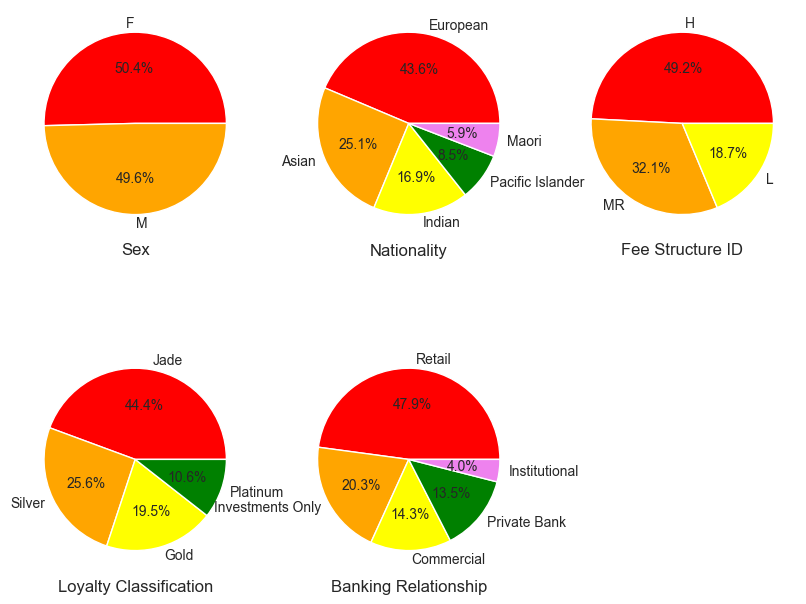

In [44]:
# Categorical features 
categorical_cols.remove('Occupation') # 195 values are not needed to be visualizied
def plot_categorical(data,categorical_cols): 
    plt.figure(figsize=(10, 8))
    colors = ['red', 'orange', 'yellow', 'green', 'violet']
    for i, col in enumerate(categorical_cols,1):
        plt.subplot(2,3,i)
        data[col].value_counts().plot.pie(autopct='%1.1f%%', textprops={'fontsize':10},
                                      colors=colors[:len(data[col].value_counts())])
        plt.ylabel('')  # Remove y-axis label to avoid clutter  
        plt.xlabel(col)
    plt.show()   
plot_categorical(data,categorical_cols)

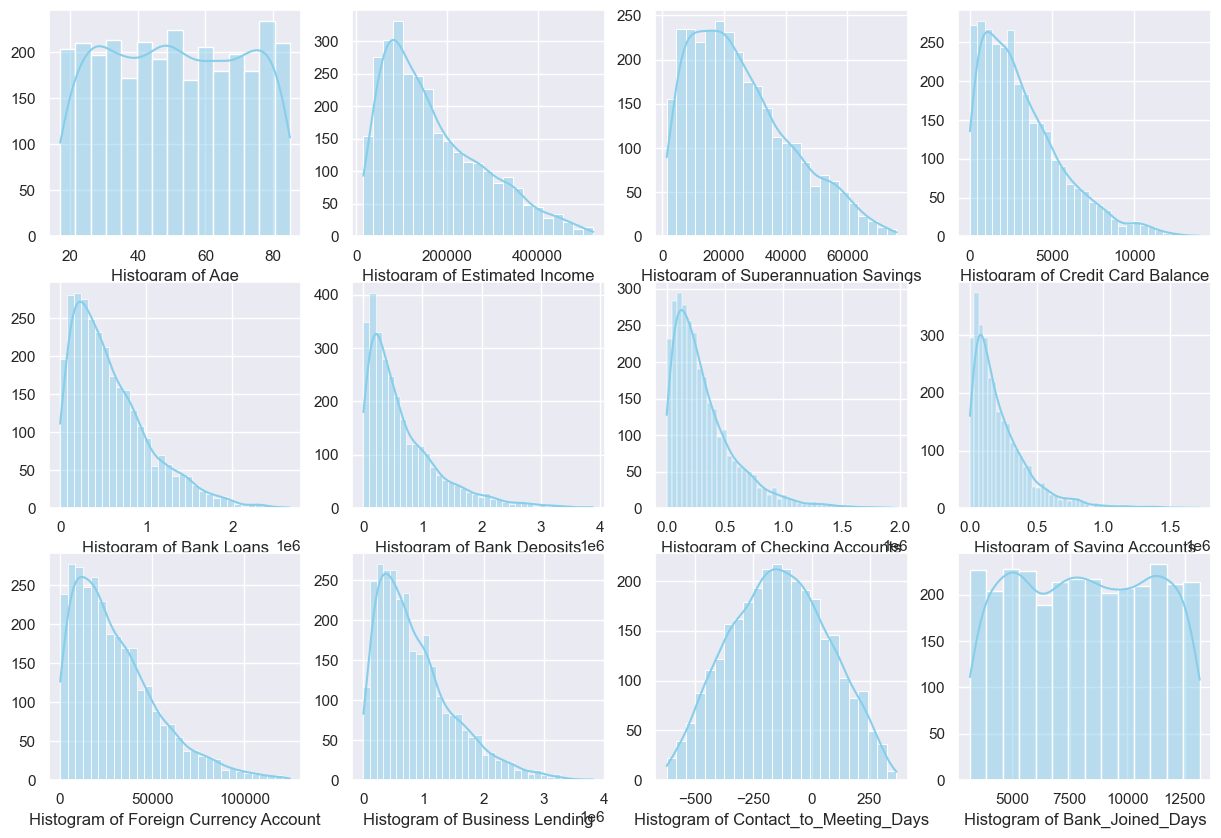

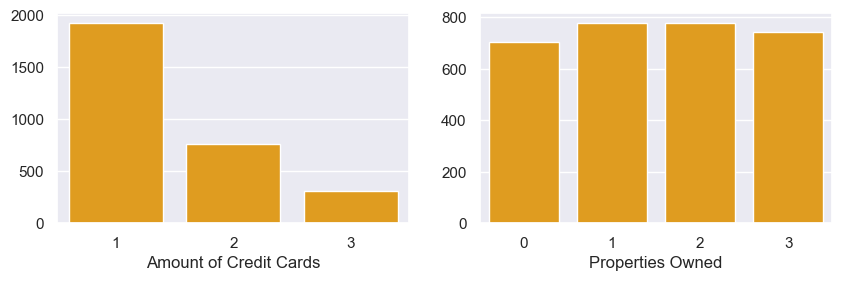

In [45]:
# Plot histogram for continuous columns
def plot_numerical(data, continuous_cols, discrete_cols): 
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(continuous_cols,1):
        plt.subplot(3,4,i)   
        sns.histplot(data[col], kde=True, color='skyblue')
        plt.xlabel(f'Histogram of {col}')
        plt.ylabel('')
    plt.show()

    plt.figure(figsize=(10,6))
    for i, col in enumerate(discrete_cols,1):
        plt.subplot(2,2,i) 
        sns.countplot(x=data[col],data=data,color='orange')
        plt.xlabel(col)
        plt.ylabel('')
    plt.show()
plot_numerical(data, continuous_cols, discrete_cols) 
 

### Detecting outliers


In [46]:
# Let's check for outliers by applying the IQR method and plot them with box
def detect_outliers(data, continuous_cols):
    Q1 = data[continuous_cols].quantile(0.25)
    Q3 = data[continuous_cols].quantile(0.75)
    IQR = Q3-Q1
    outliers = ((data[continuous_cols] < (Q1-1.5 * IQR)) | (data[continuous_cols] > (Q3 + 1.5 * IQR)))
    return outliers
outliers = detect_outliers(data, continuous_cols)
outliers.sum()

Age                           0
Estimated Income             26
Superannuation Savings       19
Credit Card Balance          85
Bank Loans                   85
Bank Deposits               149
Checking Accounts           138
Saving Accounts             155
Foreign Currency Account     79
Business Lending             93
Contact_to_Meeting_Days       0
Bank_Joined_Days              0
dtype: int64

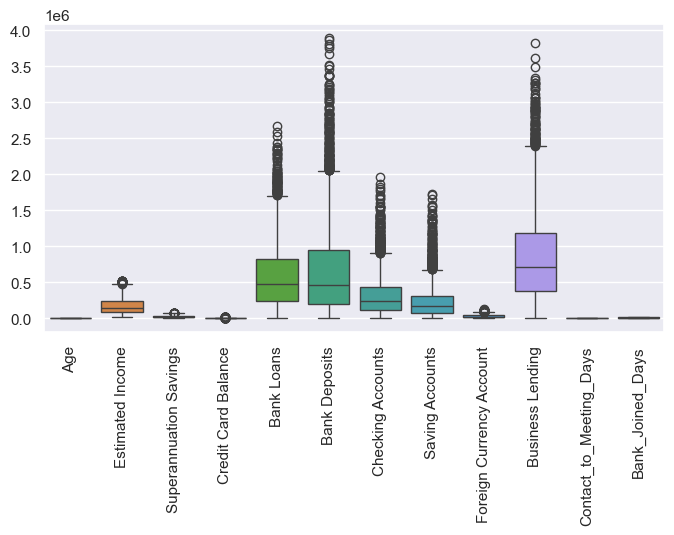

In [47]:
# Plot the outliers 
def plot_density(data,cols):
    plt.figure(figsize=(8, 4))
    # Plot the boxplot
    # data[continuous_cols].boxplot()
    sns.boxplot(data=data[cols])
    # Rotate x-axis labels by 45 degrees
    plt.xticks(rotation=90)
    # Display the plot
    plt.show()
plot_density(data,continuous_cols)  

### Correlation

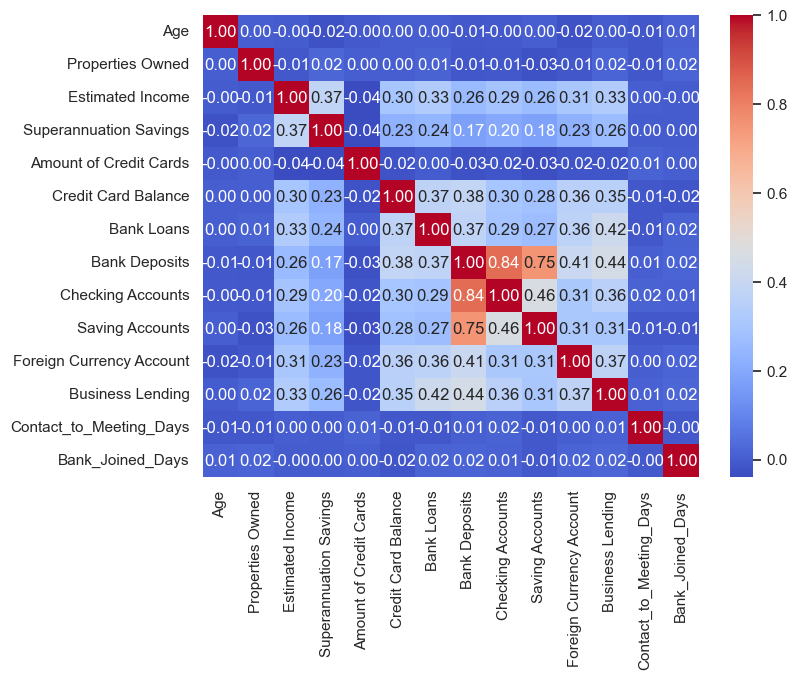

In [48]:
# What's the correlation between features? Numerical 

correlation = data[numeric_cols].corr()
plt.figure(figsize = (8,6))
sns.heatmap(correlation, annot=True, fmt='.2f', cmap = 'coolwarm')
plt.show()

In [49]:
# correlation heatmap df
correlation = data[numeric_cols].corr()

# Get column pairs with correlation > 0.5
high_corr_pairs = []
for i in range(len(correlation.columns)):
    for j in range(i+1, len(correlation.columns)):
        if abs(correlation.iloc[i, j]) > 0.5:
            high_corr_pairs.append((correlation.columns[i], correlation.columns[j], correlation.iloc[i, j]))

# Check if there are high correlation pairs
if high_corr_pairs:
    # Print column pairs with correlation > 0.5 and their correlation values
    for pair in high_corr_pairs:
        print(pair[0], "-", pair[1], "Correlation:", pair[2])
else:
    print("No high correlation columns")

Bank Deposits - Checking Accounts Correlation: 0.8442778631339778
Bank Deposits - Saving Accounts Correlation: 0.7547444162737089


In [50]:
# These pairs of variables have a very high correlation, so it common practice to remove the most correlated one
uncorrelated_data = data.copy()
uncorrelated_data.drop(columns=['Bank Deposits'], axis=1, inplace=True)
uncorrelated_data.reset_index(drop=True)
uncorrelated_data.columns

Index(['Age', 'Sex', 'Occupation', 'Nationality', 'Fee Structure ID',
       'Loyalty Classification', 'Banking Relationship', 'Properties Owned',
       'Estimated Income', 'Superannuation Savings', 'Amount of Credit Cards',
       'Credit Card Balance', 'Bank Loans', 'Checking Accounts',
       'Saving Accounts', 'Foreign Currency Account', 'Business Lending',
       'Contact_to_Meeting_Days', 'Bank_Joined_Days'],
      dtype='object')

In [51]:
uncorrelated_data

,Age,Sex,Occupation,Nationality,Fee Structure ID,Loyalty Classification,Banking Relationship,Properties Owned,Estimated Income,Superannuation Savings,Amount of Credit Cards,Credit Card Balance,Bank Loans,Checking Accounts,Saving Accounts,Foreign Currency Account,Business Lending,Contact_to_Meeting_Days,Bank_Joined_Days
0,24,M,Safety Technician IV,Indian,H,Jade,Retail,1,75384.7686,17677.95,1,484.5440,7.762429e+05,6.036179e+05,607332.455240,12249.9584,1.134475e+06,-24,3302
1,23,M,Software Consultant,Maori,H,Jade,Retail,1,289834.3140,17398.92,1,2256.8777,1.270615e+06,2.295214e+05,344635.157402,61162.3089,2.000526e+06,78,9658
2,27,F,Help Desk Operator,European,H,Gold,Institutional,1,169935.2252,42825.90,2,4568.7438,1.052716e+06,6.526747e+05,203054.348179,79071.7794,5.481376e+05,-115,6690
3,40,M,Geologist II,Indian,MR,Silver,Investments Only,0,356808.1125,5473.15,2,4205.0010,1.211951e+05,1.048157e+06,234685.019326,57513.6520,1.148402e+06,29,12837
4,46,F,Assistant Professor,Indian,MR,Platinum,Private Bank,0,130711.6800,48077.60,1,3779.4880,1.048302e+06,4.466442e+05,128351.452320,30012.1360,1.674412e+06,104,5783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,82,F,Accounting Assistant III,Indian,H,Gold,Retail,1,297617.1424,61177.60,1,649.8540,2.239351e+05,5.328679e+05,657849.619325,12947.3100,1.238860e+06,-75,4972
2996,44,F,Paralegal,European,MR,Gold,Private Bank,1,42397.4628,33356.88,1,1639.0350,5.959020e+05,5.658174e+04,93195.608103,23205.6900,2.771711e+05,206,7044
2997,70,F,Statistician IV,Indian,L,Jade,Retail,2,48339.8784,18889.92,1,2352.8448,8.804930e+05,1.587261e+05,35539.152952,30291.8112,5.029472e+05,-106,6717
2998,56,F,Human Resources Assistant III,European,MR,Jade,Commercial,3,107265.8691,11283.09,2,3578.6088,2.686250e+05,4.046383e+05,56411.334112,6413.1444,1.538369e+06,77,8132


## Encoding categorical features


In [52]:
# Check for the values to be encoded 

ordinal_categorical = uncorrelated_data[['Fee Structure ID', 'Loyalty Classification']]
for col in ordinal_categorical:
    print(ordinal_categorical[col].unique())


['H' 'MR' 'L']
['Jade' 'Gold' 'Silver' 'Platinum']


In [53]:
# Convert categorical features into numerical using OrdinalEncoder
data_to_encode = uncorrelated_data.copy()
def ordinal_encoding(df):
    # Set order of values in each column by their rank
    # for [H' ,'MR','L' meaning 'High','Mid Range','Low' respectively ]
    fee_order = ['H','MR','L']
    loyalty_order = ['Jade', 'Silver', 'Gold', 'Platinum'] 
    
    # Initialize the OrdinalEncoder with the custom order ordinal_encoder
    ordinal_encoder = OrdinalEncoder(categories=[fee_order, loyalty_order])
    df[['Fee_Rank','Loyalty_Rank']] = ordinal_encoder.fit_transform(df[['Fee Structure ID','Loyalty Classification']])
    df[['Fee_Rank','Loyalty_Rank']] = df[['Fee_Rank','Loyalty_Rank']].astype(int)
    return df

ord_data_encoded = ordinal_encoding(data_to_encode)
ord_data_encoded.drop(['Fee Structure ID','Loyalty Classification'], axis=1, inplace=True)
ord_data_encoded.reset_index(drop=True)

,Age,Sex,Occupation,Nationality,Banking Relationship,Properties Owned,Estimated Income,Superannuation Savings,Amount of Credit Cards,Credit Card Balance,Bank Loans,Checking Accounts,Saving Accounts,Foreign Currency Account,Business Lending,Contact_to_Meeting_Days,Bank_Joined_Days,Fee_Rank,Loyalty_Rank
0,24,M,Safety Technician IV,Indian,Retail,1,75384.7686,17677.95,1,484.5440,7.762429e+05,6.036179e+05,607332.455240,12249.9584,1.134475e+06,-24,3302,0,0
1,23,M,Software Consultant,Maori,Retail,1,289834.3140,17398.92,1,2256.8777,1.270615e+06,2.295214e+05,344635.157402,61162.3089,2.000526e+06,78,9658,0,0
2,27,F,Help Desk Operator,European,Institutional,1,169935.2252,42825.90,2,4568.7438,1.052716e+06,6.526747e+05,203054.348179,79071.7794,5.481376e+05,-115,6690,0,2
3,40,M,Geologist II,Indian,Investments Only,0,356808.1125,5473.15,2,4205.0010,1.211951e+05,1.048157e+06,234685.019326,57513.6520,1.148402e+06,29,12837,1,1
4,46,F,Assistant Professor,Indian,Private Bank,0,130711.6800,48077.60,1,3779.4880,1.048302e+06,4.466442e+05,128351.452320,30012.1360,1.674412e+06,104,5783,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,82,F,Accounting Assistant III,Indian,Retail,1,297617.1424,61177.60,1,649.8540,2.239351e+05,5.328679e+05,657849.619325,12947.3100,1.238860e+06,-75,4972,0,2
2996,44,F,Paralegal,European,Private Bank,1,42397.4628,33356.88,1,1639.0350,5.959020e+05,5.658174e+04,93195.608103,23205.6900,2.771711e+05,206,7044,1,2
2997,70,F,Statistician IV,Indian,Retail,2,48339.8784,18889.92,1,2352.8448,8.804930e+05,1.587261e+05,35539.152952,30291.8112,5.029472e+05,-106,6717,2,0
2998,56,F,Human Resources Assistant III,European,Commercial,3,107265.8691,11283.09,2,3578.6088,2.686250e+05,4.046383e+05,56411.334112,6413.1444,1.538369e+06,77,8132,1,0


In [54]:
# Convert categorical features into numerical using OneHotEncoder and e
def dummy_target_encoding(df,categorical_col,target_col):
    # Create dummies (True - False) columns for features with low cardinality
    df = pd.get_dummies(df, columns = ['Sex', 'Nationality', 'Properties Owned', 'Banking Relationship']) 
    
    # Assuming that Income is mostly infuenced by Occupation, the values of Occupation feature
    # with medium cardinality are mapped with Income mean
    target_mean = df.groupby(categorical_col)[target_col].mean()
    df_encoded = df.copy()
    df[categorical_col + '_encoded'] = df[categorical_col].map(target_mean)
    return df   

encoded_data = dummy_target_encoding(ord_data_encoded,'Occupation', 'Estimated Income')
# Remove the categorical feature
encoded_data.drop(['Occupation'], axis=1, inplace=True)
encoded_data.reset_index(drop=True)
encoded_data

,Age,Estimated Income,Superannuation Savings,Amount of Credit Cards,Credit Card Balance,Bank Loans,Checking Accounts,Saving Accounts,Foreign Currency Account,Business Lending,...,Properties Owned_0,Properties Owned_1,Properties Owned_2,Properties Owned_3,Banking Relationship_Commercial,Banking Relationship_Institutional,Banking Relationship_Investments Only,Banking Relationship_Private Bank,Banking Relationship_Retail,Occupation_encoded
0,24,75384.7686,17677.95,1,484.5440,7.762429e+05,6.036179e+05,607332.455240,12249.9584,1.134475e+06,...,False,True,False,False,False,False,False,False,True,160082.776545
1,23,289834.3140,17398.92,1,2256.8777,1.270615e+06,2.295214e+05,344635.157402,61162.3089,2.000526e+06,...,False,True,False,False,False,False,False,False,True,194609.135156
2,27,169935.2252,42825.90,2,4568.7438,1.052716e+06,6.526747e+05,203054.348179,79071.7794,5.481376e+05,...,False,True,False,False,False,True,False,False,False,160444.196785
3,40,356808.1125,5473.15,2,4205.0010,1.211951e+05,1.048157e+06,234685.019326,57513.6520,1.148402e+06,...,True,False,False,False,False,False,True,False,False,141838.132593
4,46,130711.6800,48077.60,1,3779.4880,1.048302e+06,4.466442e+05,128351.452320,30012.1360,1.674412e+06,...,True,False,False,False,False,False,False,True,False,177739.560600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,82,297617.1424,61177.60,1,649.8540,2.239351e+05,5.328679e+05,657849.619325,12947.3100,1.238860e+06,...,False,True,False,False,False,False,False,False,True,151540.295863
2996,44,42397.4628,33356.88,1,1639.0350,5.959020e+05,5.658174e+04,93195.608103,23205.6900,2.771711e+05,...,False,True,False,False,False,False,False,True,False,174890.435405
2997,70,48339.8784,18889.92,1,2352.8448,8.804930e+05,1.587261e+05,35539.152952,30291.8112,5.029472e+05,...,False,False,True,False,False,False,False,False,True,154891.334720
2998,56,107265.8691,11283.09,2,3578.6088,2.686250e+05,4.046383e+05,56411.334112,6413.1444,1.538369e+06,...,False,False,False,True,True,False,False,False,False,193562.084418


In [55]:
encoded_data.shape

(3000, 31)

# Scaling data

In [56]:
encoded_data.columns

Index(['Age', 'Estimated Income', 'Superannuation Savings',
       'Amount of Credit Cards', 'Credit Card Balance', 'Bank Loans',
       'Checking Accounts', 'Saving Accounts', 'Foreign Currency Account',
       'Business Lending', 'Contact_to_Meeting_Days', 'Bank_Joined_Days',
       'Fee_Rank', 'Loyalty_Rank', 'Sex_F', 'Sex_M', 'Nationality_Asian',
       'Nationality_European', 'Nationality_Indian', 'Nationality_Maori',
       'Nationality_Pacific Islander', 'Properties Owned_0',
       'Properties Owned_1', 'Properties Owned_2', 'Properties Owned_3',
       'Banking Relationship_Commercial', 'Banking Relationship_Institutional',
       'Banking Relationship_Investments Only',
       'Banking Relationship_Private Bank', 'Banking Relationship_Retail',
       'Occupation_encoded'],
      dtype='object')

In [57]:
# Apply StandardScaler to all values for not to weigh some features (especially) ordinal ones more
# Dummy created columns are left behind
scaler = StandardScaler() 
values_to_be_scaled = ['Age', 'Estimated Income', 'Superannuation Savings',
       'Amount of Credit Cards', 'Credit Card Balance', 'Bank Loans',
       'Checking Accounts', 'Saving Accounts', 'Foreign Currency Account',
       'Business Lending', 'Contact_to_Meeting_Days', 'Bank_Joined_Days',
       'Fee_Rank', 'Loyalty_Rank', 'Occupation_encoded']

# Scale just the features with continuous_data
scaled_data = encoded_data.copy()
scaled_data[values_to_be_scaled] = scaler.fit_transform(scaled_data[values_to_be_scaled])
scaled_data[values_to_be_scaled] 

,Age,Estimated Income,Superannuation Savings,Amount of Credit Cards,Credit Card Balance,Bank Loans,Checking Accounts,Saving Accounts,Foreign Currency Account,Business Lending,Contact_to_Meeting_Days,Bank_Joined_Days,Fee_Rank,Loyalty_Rank,Occupation_encoded
0,-1.362100,-0.857065,-0.483086,-0.685620,-1.078097,0.404075,1.001746,1.628147,-0.763157,0.417572,0.549235,-1.671164,-0.907935,-0.935051,-0.387635
1,-1.412474,1.059081,-0.500250,-0.685620,-0.368221,1.484717,-0.324684,0.485833,1.353704,1.768406,1.034975,0.520702,-0.907935,-0.935051,0.804961
2,-1.210978,-0.012239,1.063791,0.793071,0.557756,1.008413,1.175686,-0.129817,2.128802,-0.496975,0.115879,-0.502813,-0.907935,1.007576,-0.375151
3,-0.556114,1.657504,-1.233816,0.793071,0.412065,-1.027783,2.577946,0.007726,1.195795,0.439295,0.801629,1.616979,0.397820,0.036262,-1.017834
4,-0.253869,-0.362709,1.386828,-0.685620,0.241634,0.998765,0.445166,-0.454656,0.005566,1.259745,1.158791,-0.815591,0.397820,1.978889,0.222259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,1.559601,1.128622,2.192623,-0.685620,-1.011886,-0.803205,0.750888,1.847816,-0.732977,0.580388,0.306365,-1.095264,-0.907935,1.007576,-0.682706
2996,-0.354617,-1.151812,0.481341,-0.685620,-0.615687,0.009871,-0.937875,-0.607527,-0.289008,-0.919618,1.644531,-0.380736,0.397820,1.007576,0.123846
2997,0.955111,-1.098716,-0.408537,-0.685620,-0.329783,0.631954,-0.575703,-0.858241,0.017670,-0.567461,0.158738,-0.493502,1.703575,-0.935051,-0.566956
2998,0.249873,-0.572202,-0.876441,0.793071,0.161175,-0.705518,0.296226,-0.767480,-1.015767,1.047550,1.030213,-0.005539,0.397820,-0.935051,0.768794


In [58]:
scaled_data.describe()


,Age,Estimated Income,Superannuation Savings,Amount of Credit Cards,Credit Card Balance,Bank Loans,Checking Accounts,Saving Accounts,Foreign Currency Account,Business Lending,Contact_to_Meeting_Days,Bank_Joined_Days,Fee_Rank,Loyalty_Rank,Occupation_encoded
count,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03
mean,-1.231607e-16,-1.699381e-16,1.859253e-16,-1.065814e-17,-8.526513e-17,1.456613e-16,2.368476e-17,-6.987004e-17,-6.158037e-17,-2.226367e-16,8.289665e-17,-1.421085e-17,-5.210647e-17,-4.766558e-17,-6.797526e-16
std,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00
min,-1.714719e+00,-1.388398e+00,-1.479314e+00,-6.856195e-01,-1.271702e+00,-1.292702e+00,-1.138496e+00,-1.012780e+00,-1.291372e+00,-1.351939e+00,-2.308058e+00,-1.715649e+00,-9.079350e-01,-9.350512e-01,-2.543122e+00
25%,-8.583588e-01,-7.898561e-01,-8.007401e-01,-6.856195e-01,-7.768614e-01,-7.689023e-01,-7.131994e-01,-6.875433e-01,-7.775871e-01,-7.673010e-01,-7.460709e-01,-8.945619e-01,-9.079350e-01,-9.350512e-01,-6.849441e-01
50%,-1.998175e-03,-2.590448e-01,-1.952511e-01,-6.856195e-01,-2.464899e-01,-2.439288e-01,-2.775470e-01,-2.992650e-01,-2.398652e-01,-2.424574e-01,-7.936924e-04,-4.849507e-03,3.978200e-01,3.626237e-02,3.224948e-02
75%,9.047366e-01,6.342663e-01,6.109979e-01,7.930710e-01,5.392870e-01,5.124300e-01,4.034357e-01,3.594680e-01,5.229301e-01,4.965507e-01,7.301970e-01,8.915013e-01,3.978200e-01,1.007576e+00,7.220692e-01
max,1.710723e+00,3.136474e+00,3.102144e+00,2.271762e+00,4.332070e+00,4.538268e+00,5.846241e+00,6.484383e+00,4.103741e+00,4.615651e+00,2.406475e+00,1.723538e+00,1.703575e+00,1.978889e+00,2.777453e+00


# MODEL CREATION

# Anomaly detection with Isolation Forest algorithm
### State-of-the-art anomaly detection algorithm particularly effective for high-dimensional datasets which does not require labeled data and elatively insensitive to noise and outliers within the data, reliable for real-world datasets.
#### It works by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of that feature. It builds an ensemble of trees (forest) where anomalies are isolated quickly, resulting in shorter paths in the trees. Normal data points, on the other hand, require more splits to be isolated, leading to longer paths. The idea is that anomalies are few and different, making them easier to isolate

In [59]:
from sklearn.ensemble import IsolationForest
'''Parameters:
        n_estimators (int): The number of base estimators in the ensemble. Default is 100
        max_samples (int): The number of samples to draw from X to train each base estimator. 
        max_features (float): The number of features to draw from X to train each base estimator.
        contamination (float): The proportion of outliers in the data set. Default is 0.01 or 1% of the data
        bootstrap (bool): If True, individual trees are fit on random subsets of the training data sampled with replacement. Default is True.
        n_jobs (int) : The number of jobs to run in parallel for fit 
        random_state (int): Controls the randomness of the estimator '''
        
params = {
    'n_estimators': 100,
    'max_samples' : 256, 
    'max_features' : 1.0,
    'contamination': 0.01,
    'bootstrap': True,
    'n_jobs' : -1,
    'random_state': 42
}
        
model = IsolationForest(**params).fit(scaled_data)

# Predict anomalies on entire set, setting anomaly value -1 to a value 1 (or, yes, it is an anomaly)
anomaly_predictions = model.predict(scaled_data)

normal_points = anomaly_predictions[anomaly_predictions == 1] 
anomaly_points = anomaly_predictions[anomaly_predictions == -1] 


# Evaluate the performance
anomalies = anomaly_predictions[anomaly_predictions == 1]
print(f"Anomalies detected in entire set: {len(anomaly_points)}")


Anomalies detected in entire set: 30


In [60]:
# Set the predictions in the original dataset
anomaly_predicted_data = data_cleaned.copy()
anomaly_predicted_data['Anomaly'] = anomaly_predictions
anomaly_predicted_data['Anomaly'] = anomaly_predicted_data['Anomaly'].map({1:0, -1:1}) 
anomaly_predicted_data[anomaly_predicted_data['Anomaly'] == 1].head()


,Name,Age,Sex,Occupation,Nationality,Banking Contact,Investment Advisor,Fee Structure ID,Loyalty Classification,Banking Relationship,...,Credit Card Balance,Bank Loans,Bank Deposits,Checking Accounts,Saving Accounts,Foreign Currency Account,Business Lending,Contact_to_Meeting_Days,Bank_Joined_Days,Anomaly
26,Maria Clark,34,M,Help Desk Operator,Asian,Joe Hanson,Carl Anderson,H,Silver,Commercial,...,10639.3140,1.469913e+06,1.724818e+06,507299.499000,1.168238e+06,75592.2510,2.143826e+06,-147,5225,1
136,John Hart,31,F,Systems Administrator IV,Maori,Raymond Alexander,Jeremy Porter,H,Jade,Private Bank,...,7104.7080,9.278083e+05,1.251566e+06,441729.027990,4.289680e+05,104897.6415,9.583391e+05,18,9293,1
368,Christopher Harper,28,M,Software Engineer II,Pacific Islander,Adam Hernandez,Victor Dean,L,Jade,Commercial,...,3024.2058,1.765195e+06,2.087860e+06,677876.607100,7.117704e+05,89738.7414,8.846199e+05,-432,6401,1
376,Wayne Hart,17,F,Help Desk Technician,Asian,Adam Hernandez,Victor Dean,H,Jade,Commercial,...,1731.5175,1.876811e+06,3.498984e+06,941105.919975,9.862307e+05,94340.8425,2.627767e+06,-2,13139,1
522,Phyllis Reed,26,F,Web Developer III,European,Benjamin Kim,Eric Shaw,L,Silver,Commercial,...,583.8489,1.484948e+06,1.553626e+06,797807.709018,5.898178e+05,27489.3054,2.376662e+06,-214,5797,1


<Figure size 1000x600 with 0 Axes>

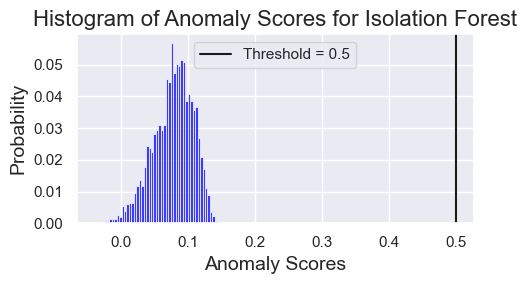

In [61]:
# Create the histogram plot
plt.figure(figsize=(10, 6))
score_threshold = 0.5  # Any datapoint with score above 0.5 is considered anomaly
anomaly_scores = model.decision_function(scaled_data)

# Create the histogram plot
plt.figure(figsize=(5, 3))
sns.histplot(anomaly_scores, kde=False, stat="probability", bins=50, color='blue')

# Add the vertical line for the threshold
plt.axvline(score_threshold, color='k', linestyle='-', label=f"Threshold = {score_threshold}")

# Add the title and labels
plt.title("Histogram of Anomaly Scores for Isolation Forest", fontsize=16)
plt.xlabel("Anomaly Scores", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

In [62]:
print(len(anomaly_scores[anomaly_scores < 0]))

30


## Anomaly detection with PCA reduced data dimesionality



In [63]:
# Apply PCA for visualization 
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)
pca_data = pd.DataFrame({'PCA Component 1':reduced_data[:, 0],'PCA Component 2':reduced_data[:, 1]})

''' Which features are the most important when reducing data to two components? '''

# Extract the loadings (principal component weights)
loadings = pca.components_.T

# Create a DataFrame to store the loadings
loadings_df = pd.DataFrame(loadings, columns=['PCA Component 1', 'PCA Component 2'])

# Adding feature names for better interpretation, assuming features are the columns in scaled_data
loadings_df.index = pd.DataFrame(scaled_data).columns

print("Feature Importances for PCA Components:")
loadings_df


Feature Importances for PCA Components:


,PCA Component 1,PCA Component 2
Age,-0.005565,0.022515
Estimated Income,0.358164,0.316062
Superannuation Savings,0.283268,0.239147
Amount of Credit Cards,-0.029277,-0.091489
Credit Card Balance,0.352692,-0.048068
Bank Loans,0.365895,-0.071955
Checking Accounts,0.355001,-0.201796
Saving Accounts,0.335028,-0.203749
Foreign Currency Account,0.361813,-0.092704
Business Lending,0.380165,-0.099781


In [64]:
print(f"Biggest influenser on PCA_1: {loadings_df.loc[loadings_df['PCA Component 1'].idxmax(), ['PCA Component 1']]}")
print(f"Biggest influenser on PCA_2: {loadings_df.loc[loadings_df['PCA Component 2'].idxmax(), ['PCA Component 2']]}")

Biggest influenser on PCA_1: PCA Component 1    0.380165
Name: Business Lending, dtype: float64
Biggest influenser on PCA_2: PCA Component 2    0.627702
Name: Occupation_encoded, dtype: float64


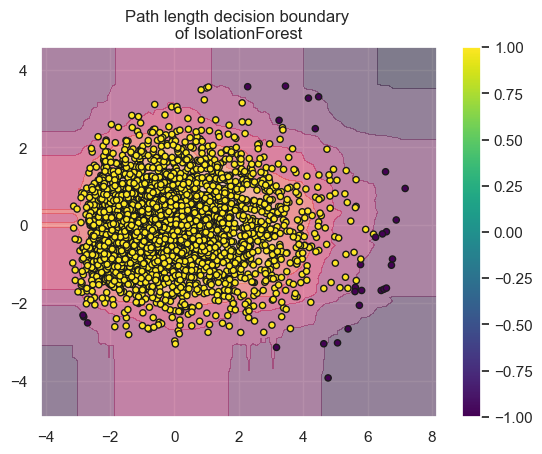

<Figure size 500x300 with 0 Axes>

In [65]:
# When a forest of random trees collectively produce short path lengths for isolating
# some particular samples, they are highly likely to be anomalies and the measure of 
# normality is close to 0. Similarly, large paths correspond to values close to 1 and are more likely to be inliers.
pca_model = IsolationForest(**params).fit(reduced_data)

disp = DecisionBoundaryDisplay.from_estimator(
    pca_model,
    reduced_data,
    response_method="decision_function",
    alpha=0.5,
)
pca_anomalies = pca_model.predict(reduced_data)

# Set axis
plt.figure(figsize=(5, 3))
disp.ax_.scatter(reduced_data[:, 0], reduced_data[:, 1], cmap='viridis', c = pca_anomalies, s=20, edgecolor="k")
disp.ax_.set_title("Path length decision boundary \nof IsolationForest")
plt.colorbar(disp.ax_.collections[1])
plt.show()


### Are model anomalies same as point anomalies (outliers)? 

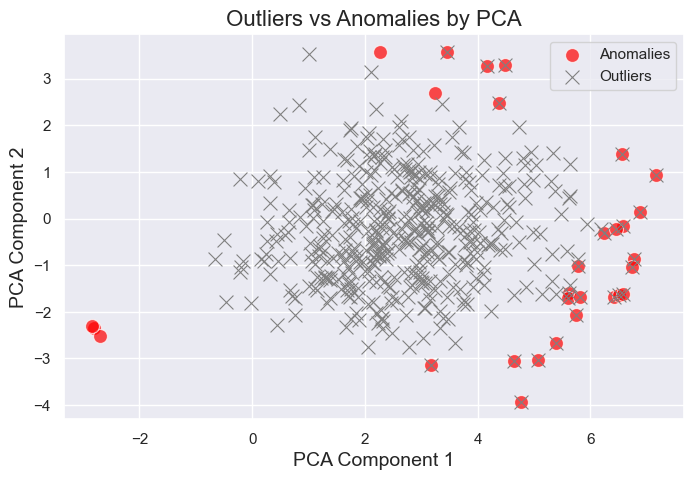

In [66]:
# Add found outliers in any axis to the comparision data
compare_data = pca_data.copy()
compare_data['Anomaly'] = pca_anomalies
compare_data['Outliers'] = outliers.any(axis=1).astype(int)

# Create the scatter plot
fig, ax = plt.subplots(figsize=(8, 5))

# Highlight the anomalies
sns.scatterplot(x='PCA Component 1', y='PCA Component 2', data=compare_data[compare_data['Anomaly'] == -1], 
                color='red', ax=ax, s=100, edgecolor='w', alpha=0.7, label='Anomalies')

# Highlight the outliers
sns.scatterplot(x='PCA Component 1', y='PCA Component 2', data=compare_data[compare_data['Outliers'] == True], 
                color='grey', marker='x', s=100, ax=ax, label='Outliers')

# Set the title and labels
ax.set_title('Outliers vs Anomalies by PCA', fontsize=16)
ax.set_xlabel('PCA Component 1', fontsize=14)
ax.set_ylabel('PCA Component 2', fontsize=14)
plt.legend()
plt.show()

### Are there any clusters that the anomalies belong to? Can clustering be used for anomaly detection?

##### Density Based Spatial Clustering of Applications with Noise (abbreviated as DBSCAN) is a density-based unsupervised clustering algorithm. In DBSCAN, clusters are formed from dense regions and separated by regions of no or low densities. Not ideal for high-dimensional data and very sensitive to ε (eps) and minPts (min_samples) parameters. The ε should be as small as possible and sometimes, domain expertise is also required to be set. For this case, KNN will help finding the optimal value. The minPts parameter is easy to set (2 * number of dimensions)

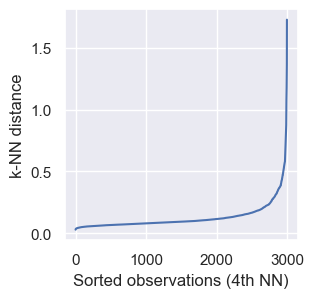

In [67]:
from sklearn.neighbors import NearestNeighbors
plt.figure(figsize=(3, 3))
# n_neighbors = 5 as kneighbors function returns distance of point to itself 
nbrs = NearestNeighbors(n_neighbors = 5).fit(reduced_data)
# Find the k-neighbors of a point
neigh_dist, neigh_ind = nbrs.kneighbors(reduced_data)
# sort the neighbor distances (lengths to points) in ascending order
# axis = 0 represents sort along first axis i.e. sort along row
sort_neigh_dist = np.sort(neigh_dist, axis = 0)
k_dist = sort_neigh_dist[:, 4]
plt.plot(k_dist)
plt.ylabel("k-NN distance")
plt.xlabel("Sorted observations (4th NN)")
plt.show()

In [68]:
# Finds the knee point in the distance curve using the KneeLocator
# Parameters:
    # neigh_dist (list): List of neighbor distances.
    # k_dist (list): List of k-distances.
kneedle = KneeLocator(x = range(1, len(neigh_dist)+1), y = k_dist, S = 1.0, 
                      curve = "concave", direction = "increasing", online=True)
# Returns: float: The y-value of the knee point in the curve
eps = kneedle.knee_y
print(f'Use {eps} as optimum value of minimim distance between the datapoints for DBSCAN clustering')

Use 0.8737555626215568 as optimum value of minimim distance between the datapoints for DBSCAN clustering


In [69]:
# Apply DBSCAN to cluster Bank clients with reduced dimesionalities
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=5)
dbscan.fit(reduced_data)

# Get cluster labels
cluster_labels = dbscan.labels_

# Add cluster labels and predictions to the pca dataframe
pca_data['Cluster'] = cluster_labels

print(f'DBSCAN found that the dataset can be divided to {pca_data['Cluster'].nunique()} clusters')

DBSCAN found that the dataset can be divided to 2 clusters


In [70]:
# Count the number of occurrences of each value in the 'Cluster' column
cluster_counts = pca_data['Cluster'].value_counts()

# Get the count of points with value -1 in the 'Cluster' column
count_of_minus_one = cluster_counts.get(-1, 0)

print(f"Number of noisy points or potential anomalies found: {count_of_minus_one}")


Number of noisy points or potential anomalies found: 7


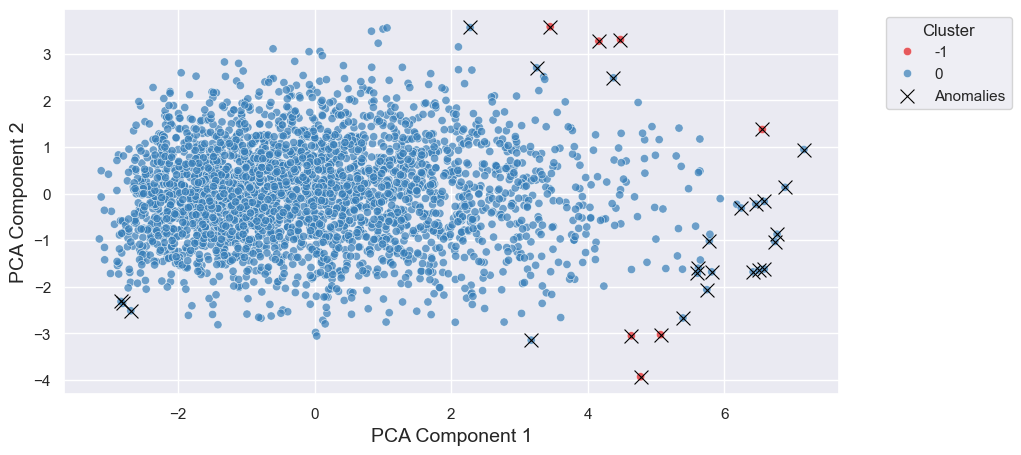

In [71]:
# Plot the clusters and anomalies belonging to a cluster
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x='PCA Component 1', y='PCA Component 2', hue='Cluster', data=pca_data, palette='Set1', edgecolor='w', alpha=0.7)
# Highlight the outliers
sns.scatterplot(x='PCA Component 1', y='PCA Component 2', data=compare_data[compare_data['Anomaly'] == -1], 
                color='black', marker='x', s=100, ax=ax, label='Anomalies')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlabel('PCA Component 1', fontsize=14)
ax.set_ylabel('PCA Component 2', fontsize=14)
plt.show()

## Let's see where do anomalies really belong

In [72]:
final_data = anomaly_predicted_data.copy()
final_data

,Name,Age,Sex,Occupation,Nationality,Banking Contact,Investment Advisor,Fee Structure ID,Loyalty Classification,Banking Relationship,...,Credit Card Balance,Bank Loans,Bank Deposits,Checking Accounts,Saving Accounts,Foreign Currency Account,Business Lending,Contact_to_Meeting_Days,Bank_Joined_Days,Anomaly
0,Raymond Mills,24,M,Safety Technician IV,Indian,Anthony Torres,Victor Dean,H,Jade,Retail,...,484.5440,7.762429e+05,1.485829e+06,6.036179e+05,607332.455240,12249.9584,1.134475e+06,-24,3302,0
1,Julia Spencer,23,M,Software Consultant,Maori,Jonathan Hawkins,Jeremy Porter,H,Jade,Retail,...,2256.8777,1.270615e+06,6.414828e+05,2.295214e+05,344635.157402,61162.3089,2.000526e+06,78,9658,0
2,Stephen Murray,27,F,Help Desk Operator,European,Anthony Berry,Ernest Knight,H,Gold,Institutional,...,4568.7438,1.052716e+06,1.033402e+06,6.526747e+05,203054.348179,79071.7794,5.481376e+05,-115,6690,0
3,Virginia Garza,40,M,Geologist II,Indian,Steve Diaz,Eric Shaw,MR,Silver,Investments Only,...,4205.0010,1.211951e+05,1.048157e+06,1.048157e+06,234685.019326,57513.6520,1.148402e+06,29,12837,0
4,Melissa Sanders,46,F,Assistant Professor,Indian,Shawn Long,Kevin Kim,MR,Platinum,Private Bank,...,3779.4880,1.048302e+06,4.877825e+05,4.466442e+05,128351.452320,30012.1360,1.674412e+06,104,5783,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,Earl Hall,82,F,Accounting Assistant III,Indian,Joshua Bennett,Daniel Carroll,H,Gold,Retail,...,649.8540,2.239351e+05,1.089957e+06,5.328679e+05,657849.619325,12947.3100,1.238860e+06,-75,4972,0
2996,Billy Williamson,44,F,Paralegal,European,Dennis Ruiz,Peter Castillo,MR,Gold,Private Bank,...,1639.0350,5.959020e+05,1.368913e+05,5.658174e+04,93195.608103,23205.6900,2.771711e+05,206,7044,0
2997,Victor Black,70,F,Statistician IV,Indian,Joshua Ryan,Steve Sanchez,L,Jade,Retail,...,2352.8448,8.804930e+05,2.148609e+05,1.587261e+05,35539.152952,30291.8112,5.029472e+05,-106,6717,0
2998,Andrew Ford,56,F,Human Resources Assistant III,European,Nicholas Cunningham,Juan Ramirez,MR,Jade,Commercial,...,3578.6088,2.686250e+05,7.426302e+05,4.046383e+05,56411.334112,6413.1444,1.538369e+06,77,8132,0


In [73]:
# Add cluster feature to the original dataset
final_data['Cluster'] = cluster_labels
# In which cluster do anomalies belong? 
clustering_anomalies = pd.crosstab(final_data['Cluster'], final_data['Anomaly'])
clustering_anomalies

Anomaly,0,1
Cluster,,
-1,4,3
0,2966,27


In [74]:
relation_anomaly = pd.crosstab(final_data['Banking Relationship'], final_data['Anomaly'])
# Calculate the percentage of anomalies
relation_anomaly['Pct'] = relation_anomaly[1] / (relation_anomaly[0] + relation_anomaly[1]) * 100

# Display the result
relation_anomaly.sort_values(by='Pct', ascending = False)

Anomaly,0,1,Pct
Banking Relationship,,,
Commercial,420,10,2.325581
Institutional,117,2,1.680672
Private Bank,400,5,1.234568
Investments Only,603,7,1.147541
Retail,1430,6,0.417827


##### Most anomalies come from Retail related clients, least - from Institutional, but the highest percentage of anomalies is detected among Commercial related clients

In [75]:
occupation_anomaly = pd.crosstab(final_data['Occupation'], final_data['Anomaly'])
# Calculate the percentage of anomalies
occupation_anomaly['Pct'] = occupation_anomaly[1] / (occupation_anomaly[0] + occupation_anomaly[1]) * 100

# Display the result
occupation_anomaly[occupation_anomaly[1] > 0].sort_values(by='Pct', ascending = False).head(5)

Anomaly,0,1,Pct
Occupation,,,
Automation Specialist IV,19,3,13.636364
Software Engineer IV,13,2,13.333333
General Manager,14,2,12.500000
Desktop Support Technician,10,1,9.090909
Web Developer II,12,1,7.692308


##### And... in Automation Specialists IV occupation group - highest number and highest ratio of anomalies

#### Should the bank be more careful with Commercial related Automation Specialists' bank accounts? 

## GET PREDICTIONS

In [76]:
# Some sample data to imitate the real data values on which model should decide whether they are anomalies
# Sample data
inputs = [
    {
    'Age': 42,
    'Estimated Income': 137256.32,
    'Superannuation Savings': 49416.00,
    'Amount of Credit Cards': 2,
    'Credit Card Balance': 2866.23,
    'Bank Loans': 856.56,
    'Checking Accounts': 1001.27,
    'Saving Accounts': 25648.23,
    'Foreign Currency Account': 79562.46,
    'Business Lending': 564.89,
    'Contact_to_Meeting_Days': 76,
    'Bank_Joined_Days': 6524,
    'Fee_Rank': 0,
    'Loyalty_Rank': 1,
    'Sex_F': 1,
    'Sex_M': 0,
    'Nationality_Asian': 0,
    'Nationality_European': 1,
    'Nationality_Indian': 0,
    'Nationality_Maori': 0,
    'Nationality_Pacific Islander': 0,
    'Properties Owned_0': 0,
    'Properties Owned_1': 1,
    'Properties Owned_2': 0,
    'Properties Owned_3': 0,
    'Banking Relationship_Commercial': 1,
    'Banking Relationship_Institutional': 0,
    'Banking Relationship_Investments Only':0,
    'Banking Relationship_Private Bank': 0,
    'Banking Relationship_Retail': 0,
    'Occupation_encoded': 166458.62
   }
]
# Convert inputs to DataFrame for easier manipulation
df_inputs = pd.DataFrame(inputs)

# Extract features for scaling
values_to_be_scaled = ['Age', 'Estimated Income', 'Superannuation Savings',
       'Amount of Credit Cards', 'Credit Card Balance', 'Bank Loans',
       'Checking Accounts', 'Saving Accounts', 'Foreign Currency Account',
       'Business Lending', 'Contact_to_Meeting_Days', 'Bank_Joined_Days',
       'Fee_Rank', 'Loyalty_Rank', 'Occupation_encoded']

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the continuous columns
df_inputs[values_to_be_scaled] = scaler.fit_transform(df_inputs[values_to_be_scaled])

# Get new prediction
is_anomaly = model.predict(df_inputs)
print(f'Prediction: Is this an anomaly: {"no" if is_anomaly == 1 else "yes"}')



Prediction: Is this an anomaly: no


### OK, that wasn't an anomaly. 

#### Conclusion: This notebook is used as a test for script creation.